In [1]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import ViTForImageClassification, ViTImageProcessor, Trainer, TrainingArguments
from torchvision.transforms import v2

2025-11-08 19:47:09.091668: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-08 19:47:09.133983: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-08 19:47:10.150030: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Loading dataset
animal_dataset = load_dataset("imagefolder", data_dir="../../../data/animal_images")
animal_dataset

Resolving data files:   0%|          | 0/30000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2407 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2407
    })
})

In [3]:
# Checking example structure of dataset in training data
features = animal_dataset["train"].features
features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Beetle', 'Butterfly', 'Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Lizard', 'Monkey', 'Mouse', 'Panda', 'Spider', 'Tiger', 'Zebra'], id=None)}

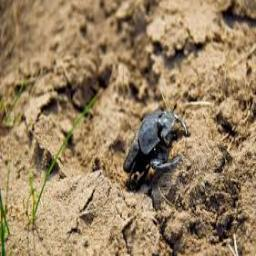

In [4]:
# Visualization of example content of dataset
animal_dataset['train'][10]['image']

In [5]:
# Splitting into seperate datasets to parse onto trainer later on
train_data = animal_dataset["train"]
validation_data = animal_dataset["validation"]
test_data = animal_dataset["test"]

In [6]:
# Label mapping for model (label-name -> index)
id2label = {id: label for id, label in enumerate(train_data.features["label"].names)}
label2id = {label: id for id, label in id2label.items()}
id2label, id2label[train_data[0]["label"]]

({0: 'Beetle',
  1: 'Butterfly',
  2: 'Cat',
  3: 'Cow',
  4: 'Dog',
  5: 'Elephant',
  6: 'Gorilla',
  7: 'Hippo',
  8: 'Lizard',
  9: 'Monkey',
  10: 'Mouse',
  11: 'Panda',
  12: 'Spider',
  13: 'Tiger',
  14: 'Zebra'},
 'Beetle')

In [7]:
# Loading model information
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [8]:
# Loading processor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224', do_rescale = False, return_tensors = 'pt')
processor

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": false,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [9]:
from torchvision import transforms 

# Get configurations from ViT processor
size = processor.size.get("height", 224)
image_mean, image_std = processor.image_mean, processor.image_std

# Normalization and augmentation transformations
transformations = {
    "train": transforms.Compose([
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.RandomResizedCrop(size),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=image_mean, std=image_std),
    ]),
    "validation": transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=image_mean, std=image_std),
    ]),
    "test": transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=image_mean, std=image_std),
    ]),
}


In [10]:
# Function to find get the specified transformation configuration and apply it to the given example for 
def transform(examples, kind="train"):
    transform_fn = transformations.get(kind, transformations["train"])
    examples["pixel_values"] = [transform_fn(img.convert("RGB")) for img in examples["image"]]
    return examples
    
# Attaching right transformations to each dataset
train_data.set_transform(lambda examples: transform(examples, "train"))
validation_data.set_transform(lambda examples: transform(examples, "validation"))
test_data.set_transform(lambda examples: transform(examples, "test"))

In [11]:
import torch
from torch.utils.data import DataLoader

# Function fixes issue with data-types, as default trainer collate function is not aware how to stack the tensors from our dataset
def collate_fn(examples):
    # Stacks the pixel values of all examples into a single tensor and collects labels into a tensor
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [12]:
from transformers import ViTForImageClassification

labels  = animal_dataset['train'].features['label'].names

# Loading model with proper label mapping
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224", 
    num_labels = len(labels),
    id2label=id2label, 
    label2id=label2id, 
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from transformers import TrainingArguments, Trainer
import numpy as np

# Training params
TRAINING_STRATEGY = "dev"
BATCH_SIZE = 32
EPOCHS = 10
STEPS = 200

train_configs = {
    "prod": TrainingArguments(
        output_dir="output-models",
        per_device_train_batch_size=BATCH_SIZE,
        eval_strategy="steps",
        save_steps=STEPS,
        eval_steps=STEPS,
        # warmup_steps=STEPS, 
        num_train_epochs=EPOCHS,
        fp16=True,
        logging_strategy="steps",
        logging_steps=STEPS,
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        remove_unused_columns=False,
        metric_for_best_model="accuracy",
        load_best_model_at_end=True,
        greater_is_better=True,
        report_to="tensorboard",
        save_strategy="steps",
        save_total_limit=3,
        seed = 123
    ),

    "prod_epoch": TrainingArguments(
        output_dir="output-models",
        per_device_train_batch_size=BATCH_SIZE,
        eval_strategy="epoch",
        eval_steps=1,
        # warmup_steps=STEPS, 
        num_train_epochs=EPOCHS,
        fp16=True,
        logging_strategy="steps",
        logging_steps=100,
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        remove_unused_columns=False,
        metric_for_best_model="accuracy",
        load_best_model_at_end=True,
        greater_is_better=True,
        report_to="tensorboard",
        save_strategy="epoch",
        save_total_limit=3,
        seed = 123
    ),

    "dev": TrainingArguments(
        output_dir="output-models",
        per_device_train_batch_size=32,
        eval_strategy="steps",
        num_train_epochs=0.01,
        fp16=True,
        save_strategy="steps",
        save_steps=10,
        eval_steps=10,
        logging_strategy="steps",
        logging_steps=10,
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        remove_unused_columns=False,
        metric_for_best_model="accuracy",
        load_best_model_at_end=True,
        greater_is_better=True,
        report_to="tensorboard",
        save_total_limit=3,
        seed = 123
    ),
}

In [14]:
import numpy as np
import evaluate
from sklearn.metrics import confusion_matrix

# Load standard evaluation metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

# Function called after completing eval strategy rule
def compute_metrics(eval_predictions):
    # Accessing model predictions
    model_calculations, true_labels = eval_predictions
    # Takes the model output with the highest value (so the most likely class to be predicted)
    model_predictions = np.argmax(model_calculations, axis=-1)

    """# Creating confusion matrix to check correctness of outputs (lines = true_labels, rows = model_predictions)
    confusion = confusion_matrix(true_labels, model_predictions)

    # Debug confusion info
    print(confusion.shape)
    print(confusion)

    # Calculation of TP, TN, FP, FN
    TP = np.diag(confusion).sum()
    FP = confusion.sum(axis=0) - np.diag(confusion)
    FN = confusion.sum(axis=1) - np.diag(confusion)
    TN = confusion.sum() - (FP + FN + np.diag(confusion)).sum()

    # Test verify accurracy
    acc = (TP + TN) / np.sum(confusion)
    print(f"Accurracy: {acc * 100:.2f}%") """
    
    # Computing all predefined metrics
    return {
        "accuracy": accuracy.compute(predictions=model_predictions, references=true_labels)["accuracy"],
        "precision": precision.compute(predictions=model_predictions, references=true_labels, average="weighted")["precision"],
        "recall": recall.compute(predictions=model_predictions, references=true_labels, average="weighted")["recall"],
        "f1": f1.compute(predictions=model_predictions, references=true_labels, average="weighted")["f1"],
    }

In [15]:
# Initializing and starting training
trainer = Trainer(
    model,
    train_configs.get(TRAINING_STRATEGY),
    train_dataset=train_data,
    eval_dataset=validation_data,
    data_collator=collate_fn,
    tokenizer=processor,
    compute_metrics=compute_metrics,
)
trainer.train()

/tmp/ipykernel_451119/3912813601.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
10,2.483500,1.982571,0.544000,0.562611,0.544000,0.503004


TrainOutput(global_step=10, training_loss=2.48345947265625, metrics={'train_runtime': 9.2357, 'train_samples_per_second': 32.483, 'train_steps_per_second': 1.083, 'total_flos': 2.480032594722816e+16, 'train_loss': 2.48345947265625, 'epoch': 0.010660980810234541})

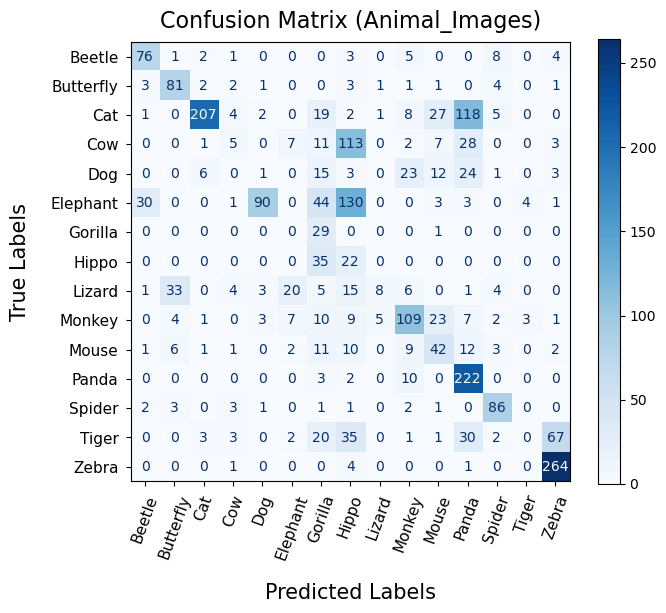



 scikit-learn report: 
              precision    recall  f1-score      support
Beetle         0.666667  0.760000  0.710280   100.000000
Butterfly      0.632812  0.810000  0.710526   100.000000
Cat            0.928251  0.525381  0.670989   394.000000
Cow            0.200000  0.028249  0.049505   177.000000
Dog            0.009901  0.011364  0.010582    88.000000
Elephant       0.000000  0.000000  0.000000   306.000000
Gorilla        0.142857  0.966667  0.248927    30.000000
Hippo          0.062500  0.385965  0.107579    57.000000
Lizard         0.533333  0.080000  0.139130   100.000000
Monkey         0.619318  0.592391  0.605556   184.000000
Mouse          0.355932  0.420000  0.385321   100.000000
Panda          0.497758  0.936709  0.650073   237.000000
Spider         0.747826  0.860000  0.800000   100.000000
Tiger          0.000000  0.000000  0.000000   164.000000
Zebra          0.763006  0.977778  0.857143   270.000000
accuracy       0.478604  0.478604  0.478604     0.478604
macro 

In [16]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Evaluation of model
predictions = trainer.predict(test_data)

# Ids of True Labels
labels_true = predictions.label_ids
# Ids of predicted labels
labels_pred = np.argmax(predictions.predictions, axis=-1)

# Configs for label <-> id mapping
id2label = model.config.id2label
label2id = model.config.label2id

# Plot of confusion matrix
result_confusion = confusion_matrix(labels_true, labels_pred)

fig, ax = plt.subplots(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=result_confusion, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=70, values_format="d", ax=ax)

ax.set_xlabel("Predicted Labels", fontsize=15, labelpad=15)
ax.set_ylabel("True Labels", fontsize=15, labelpad=15)
ax.set_title("Confusion Matrix (Animal_Images)", fontsize=16, pad=10)

ax.tick_params(axis="x", labelsize=11, pad=5)
ax.tick_params(axis="y", labelsize=11, pad=5)
plt.tight_layout()
plt.show()


# Output of sklearn classification report
report = classification_report(
    labels_true,
    labels_pred,
    target_names=labels,
    output_dict=True,
)

report_df = pd.DataFrame(report).transpose()

print(f"\n\n scikit-learn report: \n{report_df}")

report_df.to_csv("output-models/classification_report.csv", index=True)